In [1]:
import numpy as np
import matplotlib.pyplot as plt

import andes

In [2]:
%matplotlib inline

In [3]:
!andes misc --version

Python  3.12.0
andes   1.9.3
numpy   2.1.2
kvxopt  1.3.2.1
sympy   1.13.3
scipy   1.13.1
pandas  2.2.3
numba   0.61.0


In [4]:
andes.config_logger(stream_level=20)

We add a BusFreq on a generator bus, so we can use the generator's speed as an ideal speed reference.

In [5]:
ss = andes.load('./../cases/IL200_ffr.xlsx',
                setup=False,
                no_output=True,
                default_config=True,
                pert='./pert.py')

ss.add(model='Toggle', param_dict=dict(idx='Toggle_1',
                                       model='GENROU', dev='GENROU_37', t=1))

syn0 = 'GENROU_4'
# add a BusROCOF model to measure ROCOF
bus_syn0 = ss.GENROU.get(src='bus', attr='v', idx=syn0)
ss.add(model='BusROCOF', param_dict=dict(idx='BusROCOF_1', bus=bus_syn0,
                                         Tf=0.02, Tw=0.02, fn=60, Tr=0.1))

# add Output to select variabels, and thus save memory
ss.add('Output', dict(model='Bus', varname='v'))
ss.add('Output', dict(model='Bus', varname='a'))
ss.add('Output', dict(model='GENROU', varname='v'))
ss.add('Output', dict(model='GENROU', varname='omega'))
ss.add('Output', dict(model='ESD1', varname='Ipcmd_y'))
ss.add('Output', dict(model='ESD1', varname='Psum'))
ss.add('Output', dict(model='BusFreq', varname='f'))
ss.add('Output', dict(model='BusROCOF', varname='Wf_y'))
ss.add('Output', dict(model='BusROCOF', varname='f'))

ss.setup()

# increase the active power of GENROU_4
stg_syn0 = ss.GENROU.get(src='gen', attr='v', idx=syn0)
psyn0 = ss.StaticGen.get(src='p0', attr='v', idx=stg_syn0)
ss.StaticGen.alter(src='p0', attr='v', idx=stg_syn0, value=5 * psyn0)
# alleviate the corresponding TurbineGov PMAX
tg_syn0 = ss.IEEEG1.find_idx(keys='syn', values=[syn0])
ss.IEEEG1.alter(src='PMAX', attr='vin', idx=tg_syn0, value=999)

Working directory: "/Users/jinningwang/work/pmu/src/notes"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 12 processes.


Saved generated pycode to "/Users/jinningwang/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.1257 seconds.
Parsing input file "./../cases/IL200_ffr.xlsx"...
Input file parsed in 0.3488 seconds.
REPCA1 <REPCA1_1> added BusFreq <BusFreq_3> linked to bus <65.0>
REPCA1 <REPCA1_2> added BusFreq <BusFreq_4> linked to bus <104.0>
REPCA1 <REPCA1_3> added BusFreq <BusFreq_5> linked to bus <105.0>
REPCA1 <REPCA1_4> added BusFreq <BusFreq_6> linked to bus <114.0>
REPCA1 <REPCA1_5> added BusFreq <BusFreq_7> linked to bus <115.0>
REPCA1 <REPCA1_6> added BusFreq <BusFreq_8> linked to bus <125.0>
REPCA1 <REPCA1_7> added BusFreq <BusFreq_9> linked to bus <126.0>
REPCA1 <REPCA1_8> added BusFreq <BusFreq_10> linked to bus <127.0>
REPCA1 <REPCA1_9> added BusFreq <BusFreq_11> linked to bus <135.0>
REPCA1 <REPCA1_10> added BusFreq <BusFreq_12> linked to bus <136.0>
REPCA1 <REPCA1_11> added BusFreq <BusFreq_13> linked to bus <147.0>
System inte

In [6]:
# use constant power model for PQ
# this is because we add random load change in pert file

ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0

ss.PFlow.run()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0034 seconds.
0: |F(x)| = 0.4138152986
1: |F(x)| = 0.009772242847
2: |F(x)| = 3.719512348e-06
3: |F(x)| = 9.071632334e-13
Converged in 4 iterations in 0.0035 seconds.


True

In [7]:
_ = ss.TDS.init()

Perturbation file "./pert.py" loaded.
GENROU (vf range) out of typical lower limit.

   idx     | values | limit
-----------+--------+------
 GENROU_6  | 0      | 1    
 GENROU_7  | 0.859  | 1    
 GENROU_22 | 0      | 1    
 GENROU_23 | 0      | 1    
 GENROU_24 | 0      | 1    
 GENROU_25 | 0      | 1    
 GENROU_26 | 0      | 1    
 GENROU_27 | 0      | 1    
 GENROU_28 | 0      | 1    
 GENROU_29 | 0      | 1    
 GENROU_30 | 0      | 1    
 GENROU_31 | 0      | 1    
 GENROU_38 | 0.977  | 1    


/Users/jinningwang/work/miniconda3/envs/moky/lib/python3.12/site-packages/andes/core/model/model.py:780: ComplexWarning: Casting complex values to real discards the imaginary part
  instance.v = np.array(func(*self.s_args[name]),
/Users/jinningwang/work/miniconda3/envs/moky/lib/python3.12/site-packages/andes/core/model/model.py:819: ComplexWarning: Casting complex values to real discards the imaginary part
  instance.v[:] = func(*self.s_args[name])
Initialization for dynamics completed in

In [8]:
# --- hard code some attributes for FFR control ---
ss.t0 = np.array([0], dtype=float)  # last time stamp
ss.dt = np.array([0], dtype=float)  # current time step

# This can be removed later
ss.busf_idx = ss.ESD1.busf.v

# ideal speed source
ss.syn0 = syn0
ss.omega = np.array(ss.GENROU.get(src='omega', attr='v', idx=[ss.syn0]),
                    dtype=float)

a_slack = ss.Bus.get(src='a', attr='v', idx=ss.Slack.bus.v)
a_syn0 = ss.GENROU.get(src='a', attr='v', idx=ss.syn0)
ss.a0 = np.array(a_syn0 - a_slack, dtype=float)  # initial phase
v_syn0 = ss.GENROU.get(src='v', attr='v', idx=ss.syn0)

# Synthetic Point on Wave (PoW) value. Initial phase is assumed to be 0
ss.fb = np.array([2 * np.pi * ss.config.freq], dtype=float)
ss.vpow = np.array(v_syn0 * np.sin(ss.fb * ss.omega * ss.dae.t + ss.a0),
                   dtype=float)

ss.df = np.array([0], dtype=float)  # freq. deviation

ss.fn = ss.BusFreq.get(src='fn', attr='v', idx=ss.ESD1.busf.v)  # nominal freq.

ss.fdb = np.array([0.02], dtype=float)  # freq. deadband

ss.ue = np.array([0], dtype=bool)  # enable flag
ss.Kp = np.array([-0.5], dtype=float)  # PI control proportional gain, Kp
ss.Ki = np.array([-0.05], dtype=float)  # PI control integral gain, Ki
ss.Integral = np.array([0], dtype=float)  # PI control integral part
ss.PIy = np.array([0], dtype=float)  # PI control output

# --- random load disturbance ---
ss.p0 = ss.PQ.get(src='p0', attr='v', idx='PQ_1').copy()
ss.loc = np.array([0], dtype=float)  # location of the disturbance
ss.scale = np.array([0.1], dtype=float)  # scale of the disturbance
ss.dp = np.array([0], dtype=float)  # disturbance

In ANDES, ``pert`` is executed ahead of the TDS step, as shown in https://github.com/CURENT/andes/blob/1eecc207ec92efa189dc6c407aebc2a9c42428b3/andes/routines/tds.py#L389-L397

In [9]:
# --- TDS config ---
ss.TDS.config.tstep = 0.001
ss.TDS.config.tf = 5

ss.TDS.config.criteria = 0  # turn off the criteria check for testing purpose
ss.TDS.config.no_tqdm = False

# --- TDS run ---
ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-5 s.
Fixed step size: h=1 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

<Toggle Toggle_1>: GENROU.GENROU_37 status changed to 0 at t=1.0 sec.


Simulation to t=5.00 sec completed in 19.2248 seconds.


True

In [10]:
tdf = ss.dae.ts.df_xy.copy()

In [11]:
# NOTE: below values are hard coded
v_es = tdf['v Bus 52'].values
Ip_es = tdf['Ipcmd_y ESD1 1'].values
P_es = ss.config.mva * v_es * Ip_es

vsyn = tdf['v Bus 52'].values
omegasyn = tdf['omega GENROU 4'].values

vpow = vsyn * np.sin(omegasyn * ss.fb * ss.dae.ts.t + ss.a0)

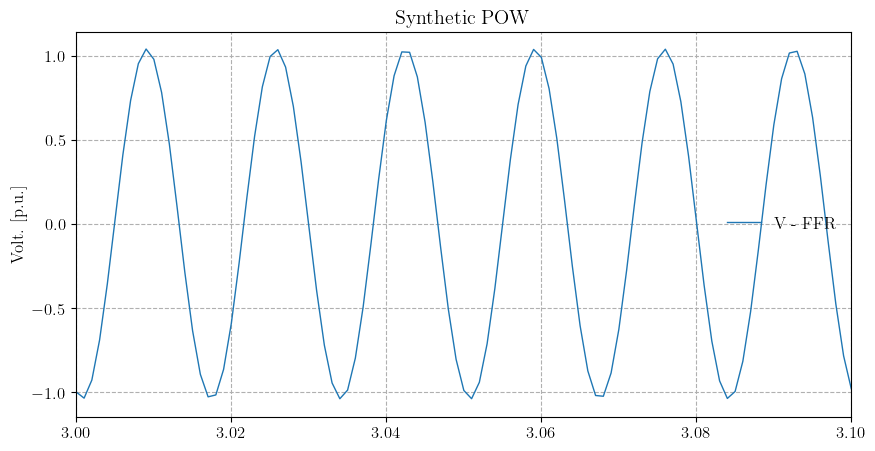

In [12]:
figp, axp = ss.TDS.plt.plot_data(ss.dae.ts.t,
                                 vpow,
                                 left=3, right=3.1,
                                 grid=True, show=False,
                                 title='Synthetic POW',
                                 ylabel='Volt. [p.u.]',
                                 yheader=['V - FFR'],
                                 figsize=(10, 5))

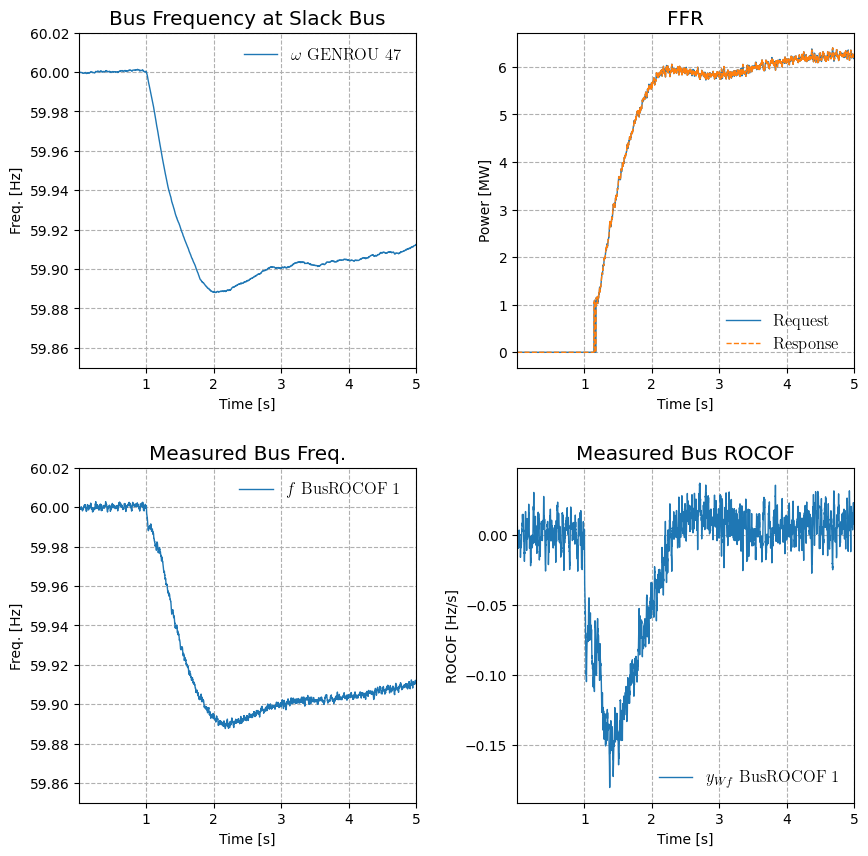

In [13]:
plt.style.use('default')

fig, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=100)
plt.subplots_adjust(hspace=0.3, wspace=0.3)

syn_slack = ss.SynGen.find_idx(keys='gen', values=ss.Slack.idx.v)
a_slack = ss.SynGen.idx2uid(syn_slack)
fmin, fmax = 59.85, 60.02
_ = ss.TDS.plt.plot(ss.GENROU.omega,
                    a=a_slack,
                    ytimes=ss.config.freq,
                    ymin=fmin, ymax=fmax,
                    grid=True, show=False,
                    title='Bus Frequency at Slack Bus',
                    ylabel='Freq. [Hz]',
                    fig=fig, ax=ax[0, 0],)

_ = ss.TDS.plt.plot(ss.ESD1.Psum,
                    ytimes=ss.config.mva,
                    grid=True, show=False,
                    title='FFR',
                    ylabel='Power [MW]',
                    yheader=['Request'],
                    fig=fig, ax=ax[0, 1],)
_ = ss.TDS.plt.plot_data(ss.dae.ts.t,
                         P_es,
                         ytimes=ss.config.mva,
                         grid=True, show=False,
                         linestyles=['--'],
                         yheader=['Response'],
                         fig=fig, ax=ax[0, 1],)

_ = ss.TDS.plt.plot(ss.BusROCOF.f,
                    ytimes=ss.BusROCOF.fn.v,
                    ymin=fmin, ymax=fmax,
                    grid=True, show=False,
                    title='Measured Bus Freq.',
                    ylabel='Freq. [Hz]',
                    fig=fig, ax=ax[1, 0],)
_ = ss.TDS.plt.plot(ss.BusROCOF.Wf_y,
                    ytimes=ss.config.freq,
                    grid=True, show=False,
                    title='Measured Bus ROCOF',
                    ylabel='ROCOF [Hz/s]',
                    fig=fig, ax=ax[1, 1],)